Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 200, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 200, 256)       │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 200, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 407,171 (1.55 MB)

 Trainable params: 407,169 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Final Test Accuracy on New Dataset: 86.96399927139282%
782/782 ━━━━━━━━━━━━━━━━━━━━ 111s 141ms/step

Evaluation Metrics:
Accuracy:  86.96%
Precision: 0.8495
Recall:    0.8984
F1-score:  0.8733

Detailed Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.84      0.87     12500
    positive       0.85      0.90      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



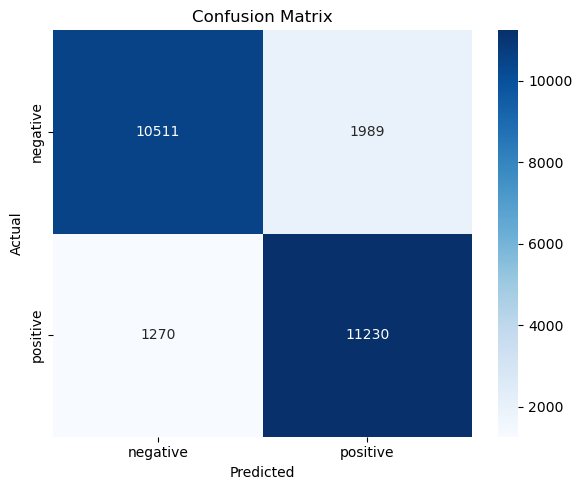

In [8]:
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec


def simple_tokenize(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    return text.split()

def tokens_to_vectors(tokens, w2v_model):
    return [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]


# Load data
new_data_path = 'enter_test_data_file.csv'
df_new = pd.read_csv(new_data_path)

# Create 'tokens' column BEFORE training Word2Vec
df_new['tokens'] = df_new['review'].apply(simple_tokenize)


w2v_model = Word2Vec.load('word2vec_model.model')

# Convert tokens to vectors
vector_sequences_new = [tokens_to_vectors(tokens, w2v_model) for tokens in df_new['tokens']]

# Pad sequences
max_len = 200
padded_sequences_new = pad_sequences(vector_sequences_new, maxlen=max_len, dtype='float32',
                                     padding='post', truncating='post', value=0.0)

# Load trained Keras model
model = load_model('best_model.h5')

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Print model architecture
print("Model Summary:")
model.summary()

# Predict or evaluate
if 'sentiment' in df_new.columns:
    label_encoder = LabelEncoder()
    y_true = label_encoder.fit_transform(df_new['sentiment'])
    loss, accuracy = model.evaluate(padded_sequences_new, y_true, verbose=0)
    print(f'Final Test Accuracy on New Dataset: {accuracy * 100:}%')

    y_pred_probs = model.predict(padded_sequences_new)
    y_pred = (y_pred_probs >= 0.5).astype(int)

    print("\nEvaluation Metrics:")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred) * 100:.2f}%")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1-score:  {f1_score(y_true, y_pred, zero_division=0):.4f}")
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
else:
    predictions = model.predict(padded_sequences_new)
    predicted_labels = ["positive" if pred >= 0.5 else "negative" for pred in predictions]
    df_new['predicted_sentiment'] = predicted_labels
    print(df_new[['review', 'predicted_sentiment']].head())

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
